In [1]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
from SimPEG.utils.code_utils import validate_ndarray_with_shape
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import warnings
import random

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)

from scipy.ndimage import laplace

class plot_mref(directives.InversionDirective):

    mesh = None
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        meshCore = self.mesh
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            self.opt.xc, ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            # clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        # utils.plot2Ddata(
        #     meshCore.gridCC,1 / np.exp(mtrue[actcore]),nx=500,ny=500,
        #     contourOpts={'alpha':0},
        #     clim=[0,500],
        #     ax=ax[0],
        #     level=True,
        #     ncontour=2,
        #     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        #     method='nearest'
        # )

        ax[2].hist(1 / np.exp(self.opt.xc), 100)
        # ax[2].set_aspect(1)

        # ax[0].set_ylim([-15,0])
        # ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        # ax[1].set_ylim([-15,0])
        # ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        fig.savefig(f'./iterations/{self.start}.png')
        np.save(f'./iterations/model_{self.start}.npy', self.opt.xc)
        plt.show()
        self.start += 1


# update the neighbors
class segment_iter(directives.InversionDirective):

    seg_iter = [8]
    segmentation_model: geoseg.SamClassificationModel=None
    method = 'bound_box'
    reg_rots = np.zeros(0)

    def rotation_matrix(self, angle):
        theta = np.radians(angle)
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        return np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

    
    def initialize(self):
        self.count = 0
    
    def endIter(self):

        print(f"Segmenting-iteration: {self.opt.iter}")
        # if self.opt.iter in self.seg_iter:
        if self.invProb.phi_d < 800.0:
            
            # self.reg[1][1].update_gradients(self.opt.xc)
            masks = self.segmentation_model.fit(self.opt.xc)

            mesh = self.segmentation_model.mesh
            reg_dirs = [np.identity(2) for _ in range(mesh.nC)]
            sqrt2 = np.sqrt(2)
            reg_rots = np.zeros(mesh.nC) + 90

            # loop through masks and assign rotations
            for ii in range(1, len(masks)):
                seg_data = masks[ii]['segmentation']
                seg_data = np.flip(seg_data)
                # Find the coordinates of the object pixels
                object_pixels = np.argwhere(seg_data == 1)

                # Apply PPCA to determine orientation
                if len(object_pixels) > 1:
                    # Standardize the data
                    scaler = StandardScaler()
                    object_pixels_std = scaler.fit_transform(object_pixels)

                    # Apply PPCA
                    pca = PCA(n_components=2)
                    pca.fit(object_pixels_std)

                    # The first principal component (eigenvector) will represent the orientation
                    orientation_vector = pca.components_[0]
                    scales = pca.singular_values_

                    # Compute the angle of the orientation vector (in degrees)
                    angle_degrees = np.abs(np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi)

                    print(f"Orientation angle (degrees): {angle_degrees} and scales: {scales}")
                    angle_radians = angle_degrees * np.pi / 180
                    
                    # rotation_matrix = 1 / np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],])
                    alphas = np.ones((mesh.n_cells, mesh.dim))
                    # check for rotation application method
                    if self.method == 'bound_box':
                        bbox_mask = self.segmentation_model.get_bound_box_indicies(ii)

                        flatten = bbox_mask # masks[ii]['segmentation'].flatten(order='F')
                        reshape = flatten.reshape(mesh.shape_cells, order='F')

                        plt.imshow(reshape.T)
                        plt.title(f'mask: {ii + 1}')
                        plt.gca().invert_yaxis()
                        # plt.plot([x0, x1], [y0, y1], 'ok')
                        plt.show()

                        for ii in range(mesh.nC):

                            if bbox_mask[ii] == 1:
                                # print('adjusting')
                                # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
                                reg_rots[ii] = angle_degrees
                                alphas[ii] =  [scales[1], scales[0]]

                        smoothed_rots = geoseg.gaussian_curvature(reg_rots.reshape((len(mesh.h[0]),len(mesh.h[1])), order="F"), smoothness=2).flatten(order="F")
                        # now assign the priciple axis to the rotation matrix
                        for ii in range(mesh.nC):

                            if np.abs(reg_rots[ii]) > 0:
                                # print('adjusting')
                                # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
                                rot_matrix = self.rotation_matrix(smoothed_rots[ii])
                                rotation_axis = np.array([rot_matrix[1, :].tolist(), rot_matrix[0, :].tolist(),])
                                reg_dirs[ii] = rotation_axis
                                
                        #         alphas[ii] = [150, 25]
                        # reg_dirs[bbox_mask] = [rotation_matrix] * int(bbox_mask.sum())
                    else:
                        reg_dirs[seg_data] = [rotation_matrix] * seg_data.sum()

                    reg_dirs = validate_ndarray_with_shape(
                        "reg_dirs",
                        reg_dirs,
                        shape=[(mesh.dim, mesh.dim), ("*", mesh.dim, mesh.dim)],
                        dtype=float,
                    )
                    
                    reg_seg = geoseg.GeologicalSegmentation(

                        mesh, 
                        reg_dirs=reg_dirs,
                        alphas=alphas,
                        ortho_check=False,

                    )

                    reg_small = regularization.Smallness(
                        mesh=mesh,
                        reference_model=self.reg[0][1].reference_model,
                        )


                    self.reg = reg_small + reg_seg
                    self.reg.multipliers = np.r_[1e-2, 1000.0]
                    self.invProb.reg = self.reg
                    # self.invProb.beta = 100.0
                    self.reg_rots = smoothed_rots

                else:
                    raise ValueError("Not enough object pixels to determine orientation.")


        
        self.count += 1


3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]



  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/tmp/ipykernel_2069105/2208726675.py:41: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_2069105/2208726675.py:62: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
/tmp/ipykernel_2069105/2208726675.py:66: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  mm = meshCore.plot_image(
/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: Runt

0.011476742793508136
149.20299953653344
0.1774185731850278 0.0028566005330678554
1.2132525501571658


Text(0.5, 1.0, 'Relative Error ($\\frac{\\sigma^{2}}{d_{obs}}$)')

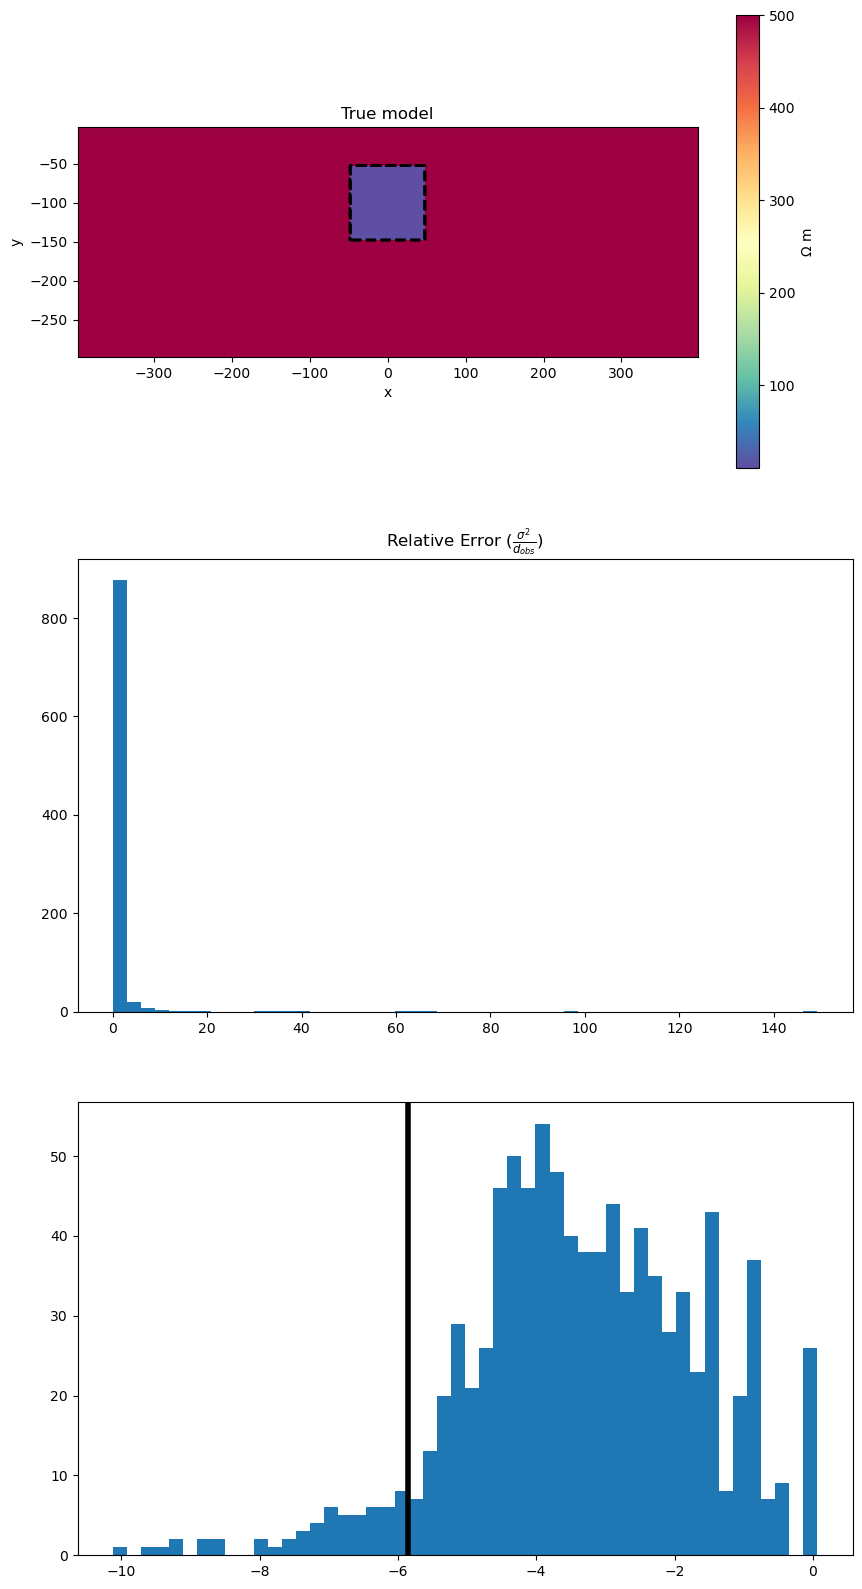

In [2]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)


# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

for ii in range(mesh.nC):

    if (-50 < mesh.gridCC[ii, 0] < 50) and \
        (-150 < mesh.gridCC[ii, 1] < -50):
        model[ii] = 4

# model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(10,20))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

ax[0].set_xlim([-1000,1000])
ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
mm = meshCore.plot_image(
    
    1/(cond_true)[actcore],
    ax=ax[0],
    pcolorOpts={'cmap':'Spectral_r'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
ax[0].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[0].set_title('True model')

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)
# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.01
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=6e-3,
    force=True,
    add_noise=True,

)

# dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.1)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list), np.quantile(np.abs(dc_data.dobs), 0.06))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[2].hist(np.log(np.abs(dc_data.dobs)), 50)
ax[2].axvline(np.log(np.quantile(np.abs(dc_data.dobs), 0.06)), color='k', linewidth=4)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')

/tmp/ipykernel_2069105/3266377348.py:114: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
/tmp/ipykernel_2069105/3266377348.py:114: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)


SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/SimPEG/directives/directives.py:332: UserWarning: There is no PGI regularization. Smallness target is turned off (TriggerSmall flag).
  getattr(r, ruleType)()


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+01  2.22e+04  0.00e+00  2.22e+04    2.28e+03      0              
Segmenting-iteration: 1
geophys. misfits: 4443.7 (target 460.0 [False])


/tmp/ipykernel_2069105/2887770123.py:72: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],


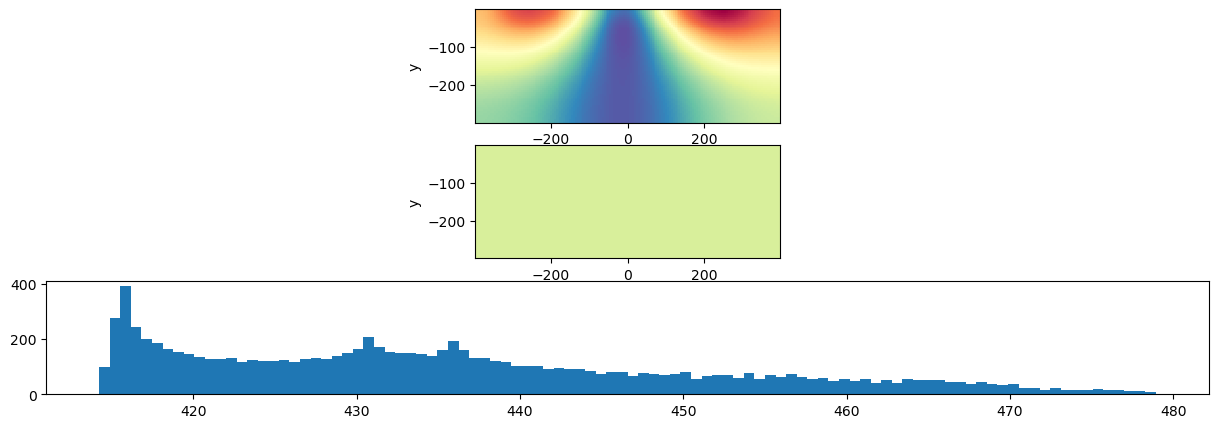

   1  1.00e+01  4.44e+03  1.81e+02  6.25e+03    1.96e+02      0              
Segmenting-iteration: 2
geophys. misfits: 4382.3 (target 460.0 [False])


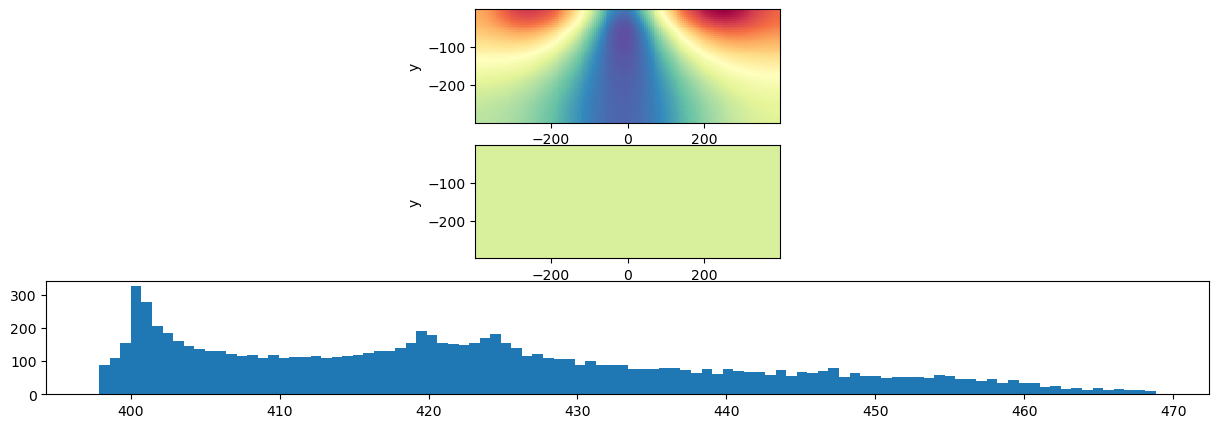

   2  5.00e+00  4.38e+03  1.72e+02  5.24e+03    2.65e+02      0              
Segmenting-iteration: 3
geophys. misfits: 3926.6 (target 460.0 [False])


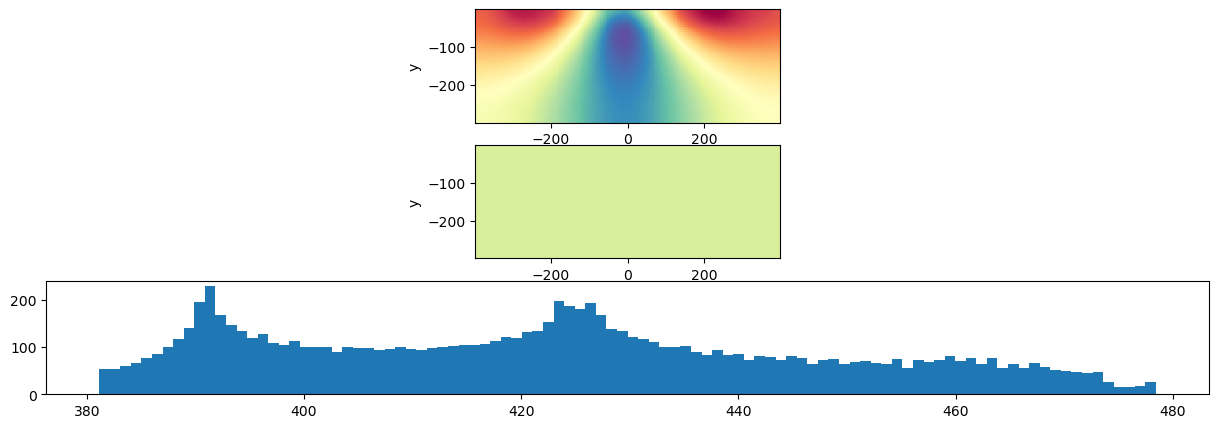

   3  5.00e+00  3.93e+03  2.38e+02  5.12e+03    1.57e+02      0              
Segmenting-iteration: 4
geophys. misfits: 3932.5 (target 460.0 [False])


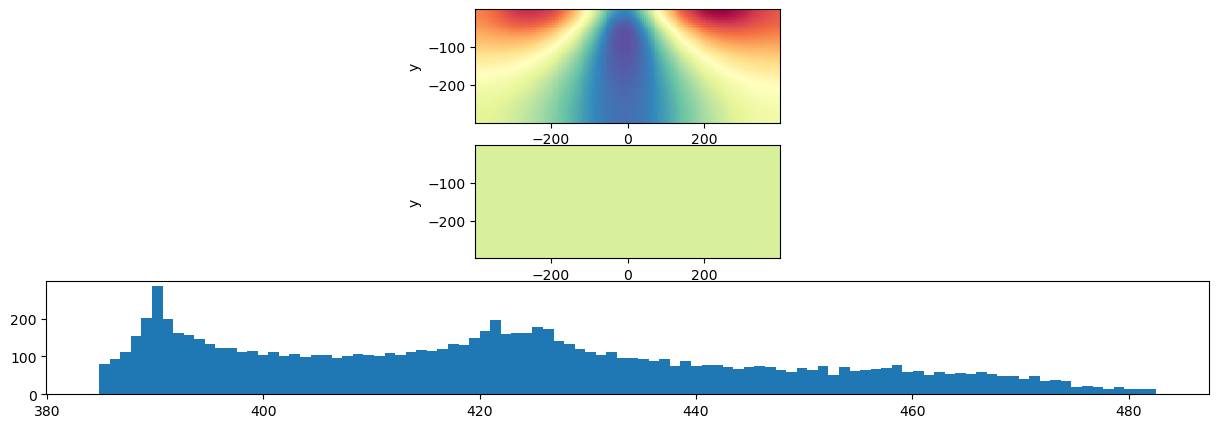

   4  2.50e+00  3.93e+03  2.34e+02  4.52e+03    2.53e+02      0              
Segmenting-iteration: 5
geophys. misfits: 3452.1 (target 460.0 [False])


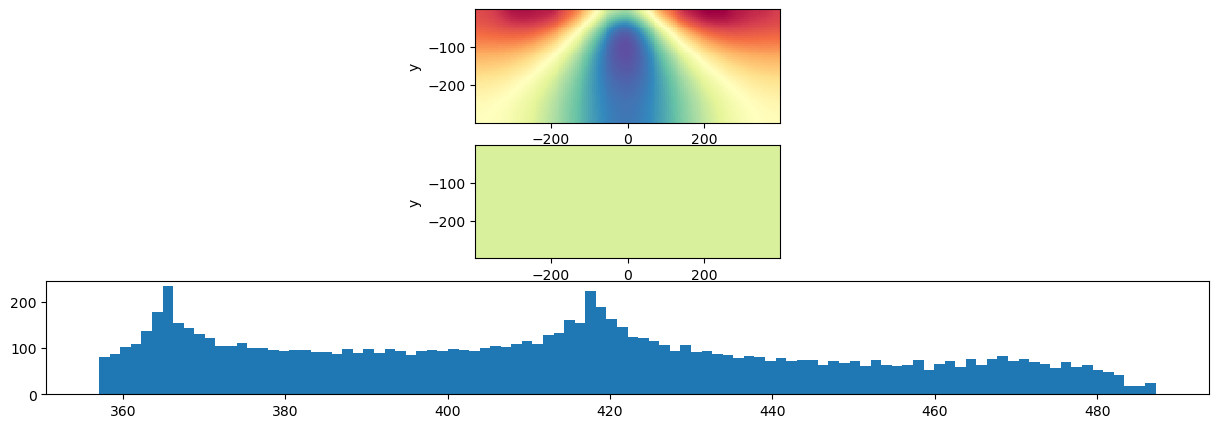

   5  2.50e+00  3.45e+03  3.71e+02  4.38e+03    1.44e+02      0              
Segmenting-iteration: 6
geophys. misfits: 3434.2 (target 460.0 [False])


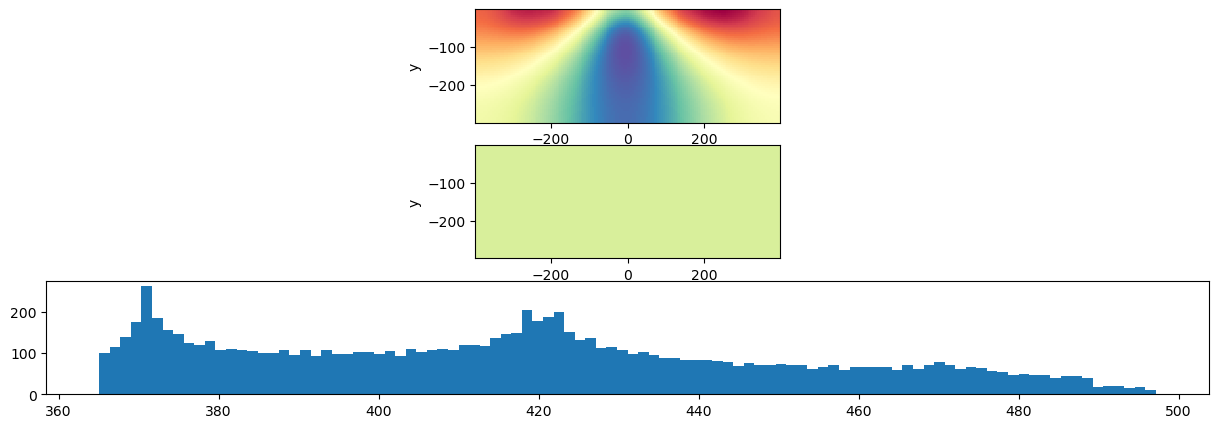

   6  1.25e+00  3.43e+03  3.64e+02  3.89e+03    1.96e+02      0              
Segmenting-iteration: 7
geophys. misfits: 2830.7 (target 460.0 [False])


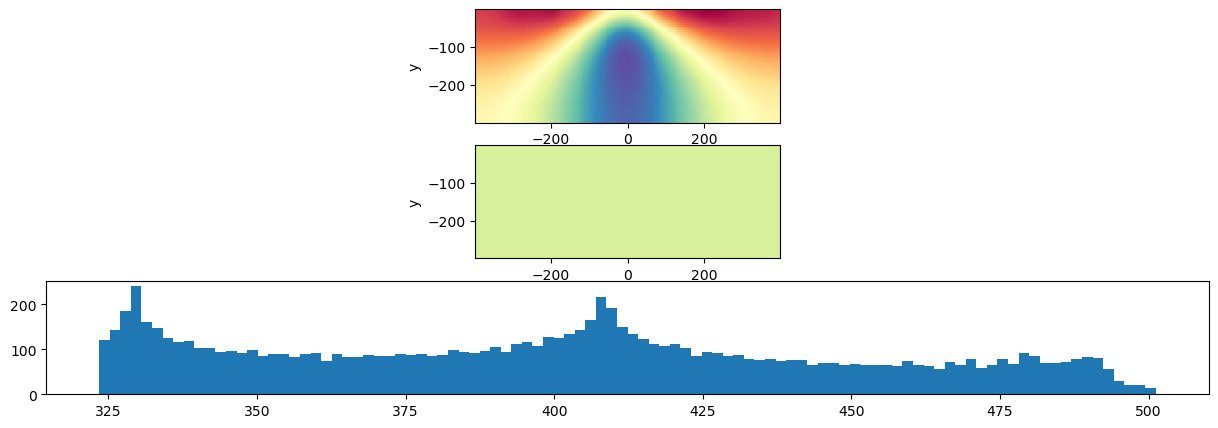

   7  1.25e+00  2.83e+03  7.02e+02  3.71e+03    9.56e+01      0              
Segmenting-iteration: 8
geophys. misfits: 2840.9 (target 460.0 [False])


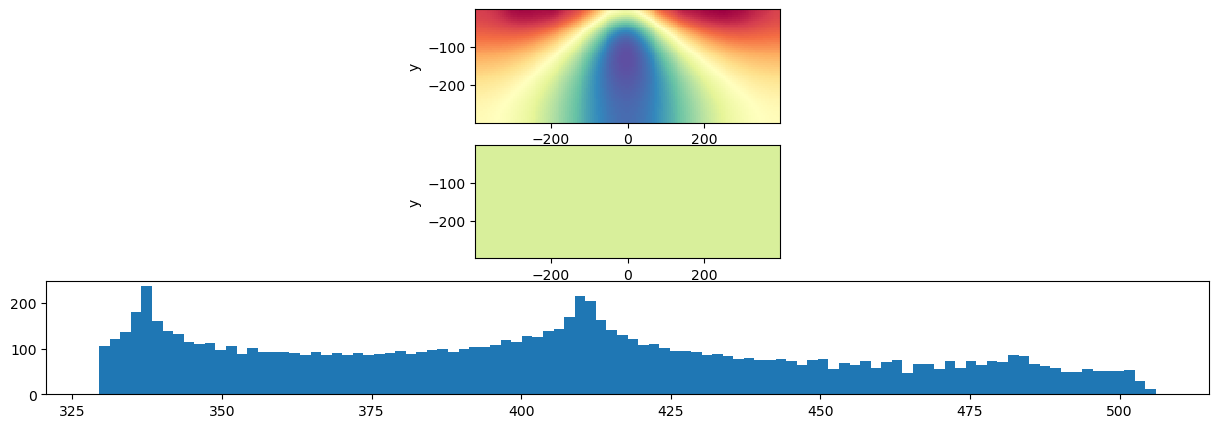

   8  6.25e-01  2.84e+03  6.80e+02  3.27e+03    1.62e+02      0              
Segmenting-iteration: 9
geophys. misfits: 2199.6 (target 460.0 [False])


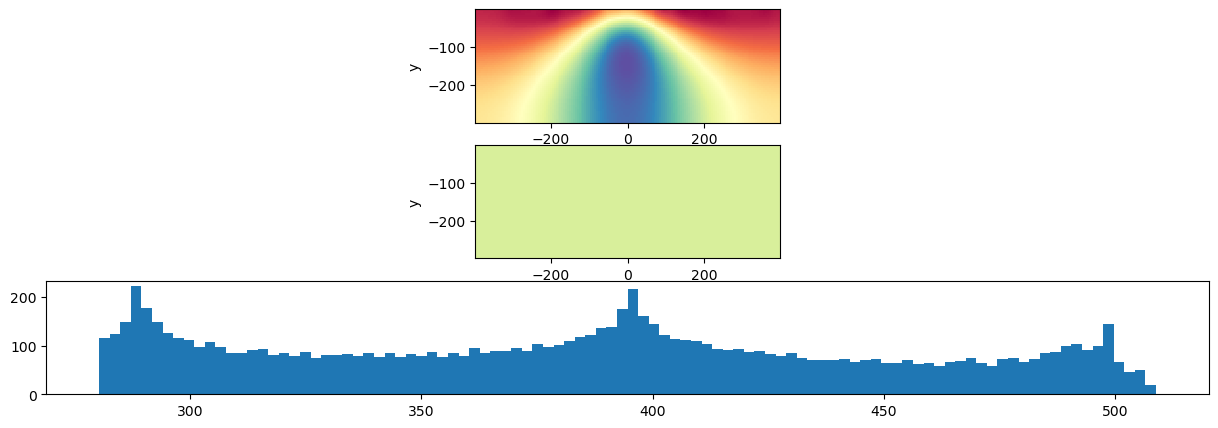

   9  6.25e-01  2.20e+03  1.40e+03  3.08e+03    8.63e+01      0              
Segmenting-iteration: 10
geophys. misfits: 2220.9 (target 460.0 [False])


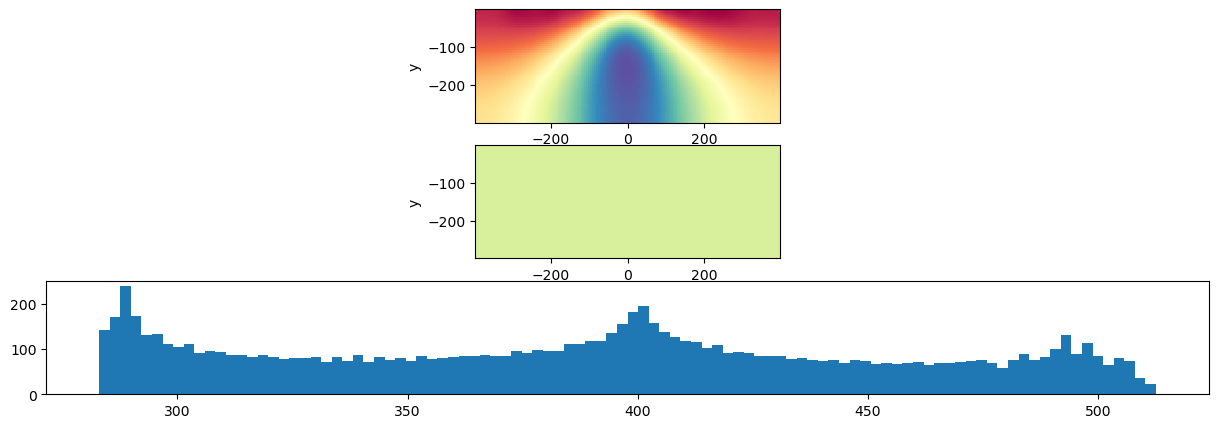

  10  3.12e-01  2.22e+03  1.35e+03  2.64e+03    1.42e+02      0              
Segmenting-iteration: 11
geophys. misfits: 1640.2 (target 460.0 [False])


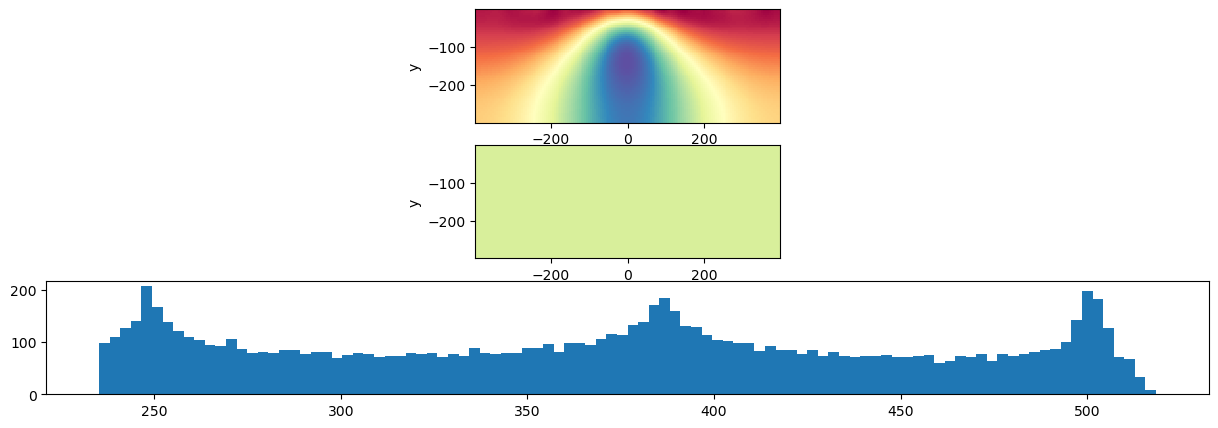

  11  3.12e-01  1.64e+03  2.65e+03  2.47e+03    8.62e+01      0              
Segmenting-iteration: 12
geophys. misfits: 1657.3 (target 460.0 [False])


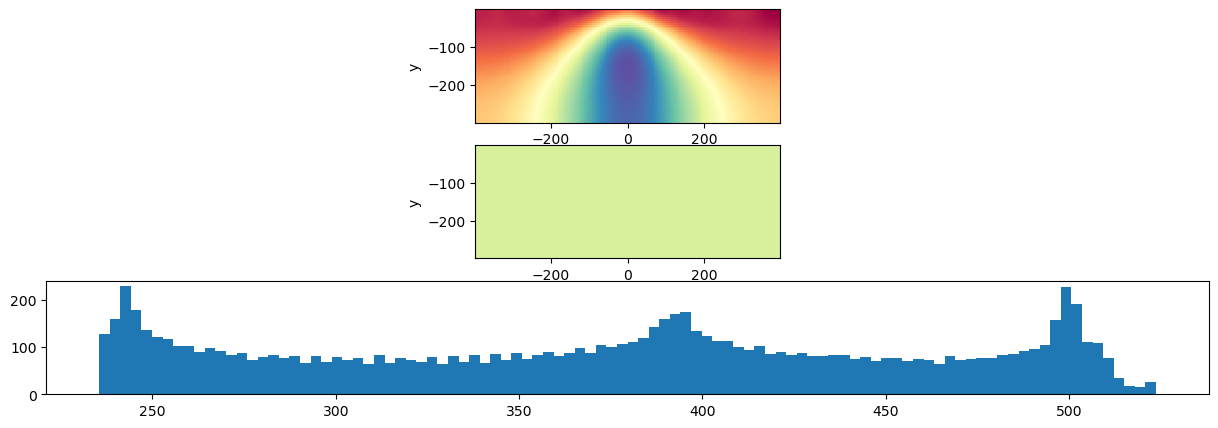

  12  1.56e-01  1.66e+03  2.56e+03  2.06e+03    1.27e+02      0              
Segmenting-iteration: 13
geophys. misfits: 1295.8 (target 460.0 [False])


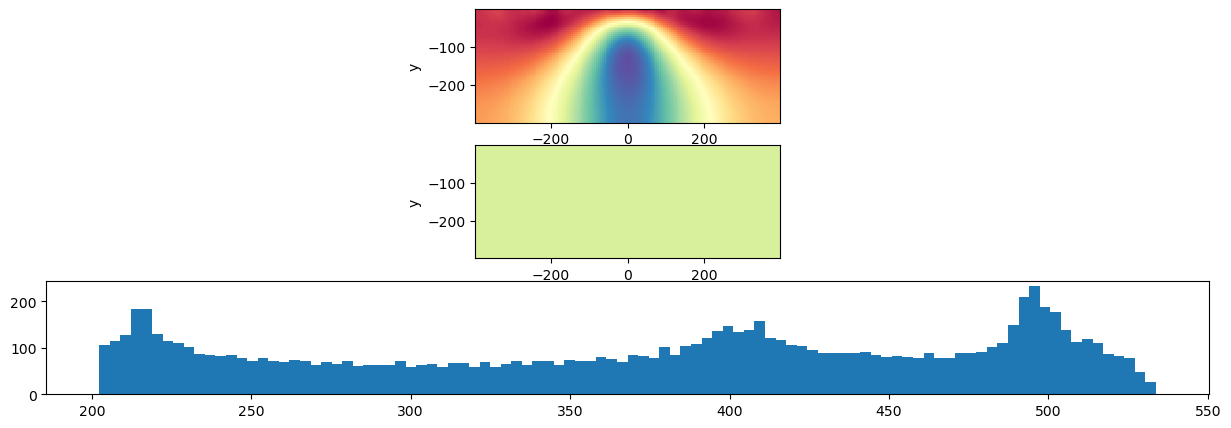

  13  1.56e-01  1.30e+03  4.09e+03  1.94e+03    7.02e+01      0              
Segmenting-iteration: 14
geophys. misfits: 1240.0 (target 460.0 [False])


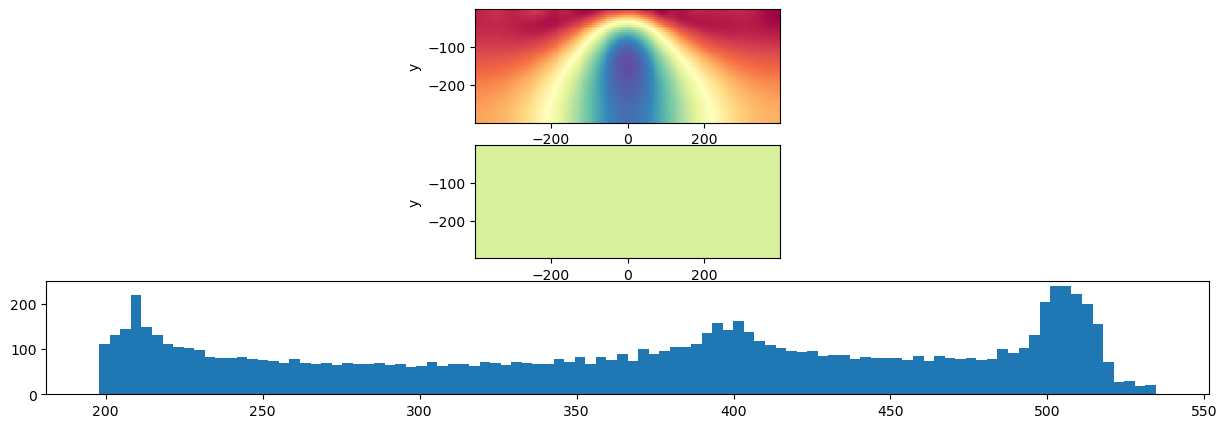

  14  7.81e-02  1.24e+03  4.26e+03  1.57e+03    7.85e+01      0              
Segmenting-iteration: 15
geophys. misfits: 1083.0 (target 460.0 [False])


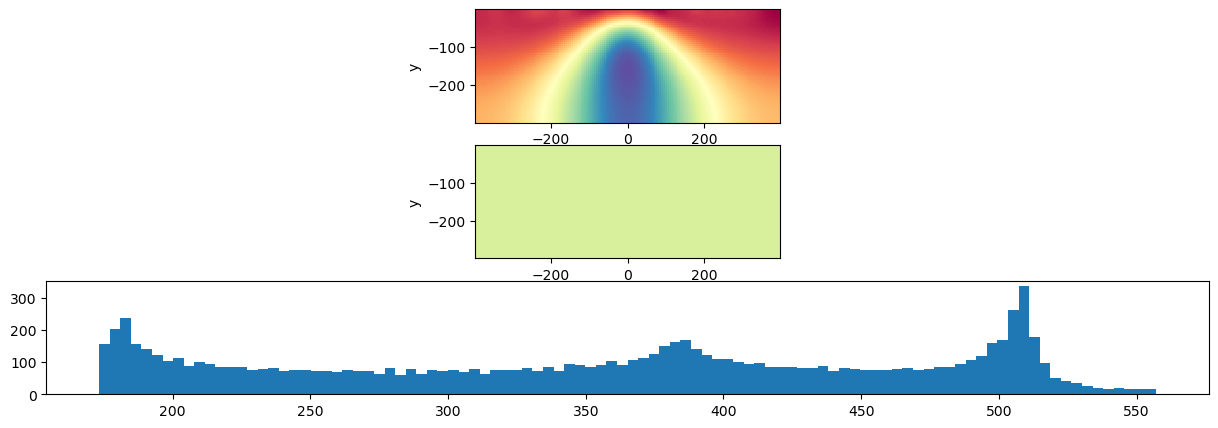

  15  7.81e-02  1.08e+03  5.49e+03  1.51e+03    1.03e+02      0              
Segmenting-iteration: 16
geophys. misfits: 1038.7 (target 460.0 [False])


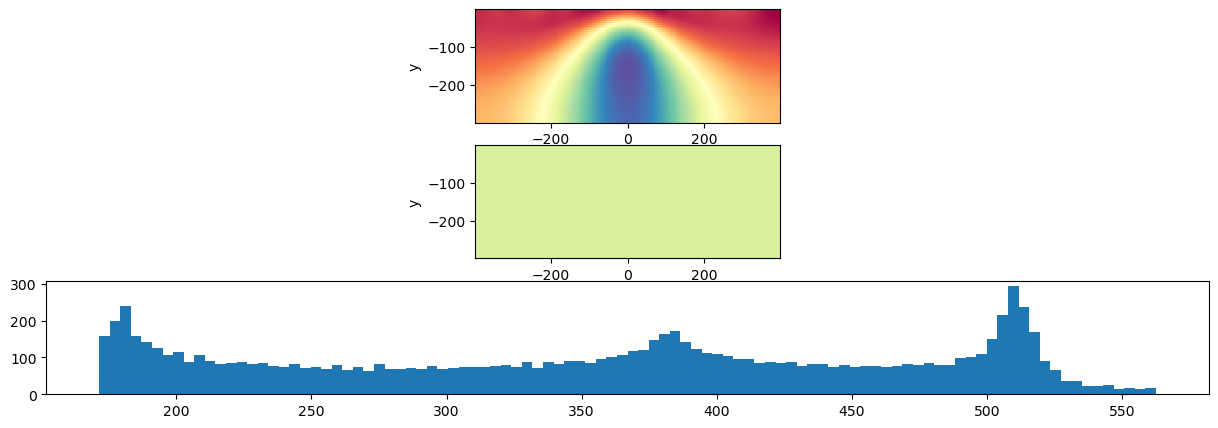

  16  3.91e-02  1.04e+03  5.70e+03  1.26e+03    8.51e+01      0              
Segmenting-iteration: 17
mask 0 vote total: 1
mask 1 vote total: 1
mask 2 vote total: 1
mask 3 vote total: 0
[1 2]
[[1.00000000e+00 4.54908737e-01 2.10782195e-01 7.90923825e-02]
 [4.54908737e-01 0.00000000e+00 4.62998102e-01 1.73624288e-01]
 [2.10782195e-01 4.62998102e-01 0.00000000e+00 3.75000000e-01]
 [7.90923825e-07 1.73624288e-06 3.75000000e-06 1.00000000e+00]]
Orientation angle (degrees): 134.99999999999994 and scales: [66.90530274 62.89420057]


TypeError: slice indices must be integers or None or have an __index__ method

In [3]:
# --------------------------------------------------------------------------

# setup the inversion

#
segmentor = geoseg.SamClassificationModel(
    meshCore,
    segmentation_model_checkpoint=r"/home/juanito/Documents/trained_models/sam_vit_h_4b8939.pth"
)
# theta = -45
# rot= np.vstack([[np.cos(theta * np.pi /180), -np.sin(theta * np.pi /180)], [np.sin(theta * np.pi /180), np.cos(theta * np.pi /180)]])


dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
# dmis.w = 1 / np.abs(dc_data.dobs * 0.05 + np.quantile(np.abs(dc_data.dobs), 0.1))
m0 = np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP)
# m0 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/guided/model_11.npy")
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))

# # load mask
# rot_mask = np.load('rotation_block_mask_scaled.npy')

# # set the regularization
# alphas = np.ones((meshCore.n_cells, meshCore.dim))
# # alphas[rot_mask] = [125, 25]
# alphas[meshCore.cell_centers[:, 1] < 0.5] = [125, 25]
# sqrt2 = np.sqrt(2)
# # reg_cell_dirs = 1 / np.array([[sqrt2, -sqrt2], [sqrt2, sqrt2],])
# # lets just assign them to the dip structure
# # reg_cell_dirs = [np.identity(2) for _ in range(meshCore.nC)]

# # lets just assign them to the dip structure
# reg_cell_dirs = [1 / np.array([[sqrt2, sqrt2], [sqrt2, sqrt2],]) for _ in range(meshCore.nC)]
# print(reg_cell_dirs)
# # lets expand the area we want to
# # Dike 45*
# dike00 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 50)
# dike01 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 255)
# dike_dir_reg = np.logical_and(dike00,dike01)

# # reg model
# reg_model = model.copy()

# reg_model[dike_dir_reg]=4

# # cos = np.cos(140*np.pi / 180) * 2
# # sin = np.sin(140*np.pi / 180) * 2

# for ii in range(meshCore.nC):

#     if rot_mask[ii] == 1:
#         print('adjusting')
#         # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
#         reg_cell_dirs[ii] = 1 / np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],])
#         alphas[ii] = [150, 25]

reg_seg = geoseg.GeologicalSegmentation(
    meshCore, 
    reg_dirs=None,
    ortho_check=False,
)

# reg_1storder = regularization.SmoothnessFullGradient(
#     meshCore, 
#     reg_dirs=reg_cell_dirs,
#     alphas=alphas,
#     ortho_check=False,
#     reference_model=np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP)
# )

reg_small = regularization.Smallness(
    mesh=meshCore,
    reference_model=np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP),
)

# # Weighting
# reg_org = regularization.WeightedLeastSquares(
#     mesh, 
#     active_cells=actcore,
#     mapping=idenMap,
#     reference_model=m0
# )

reg_mean = reg_small + reg_seg
reg_mean.multipliers = np.r_[0.01, 100.0]
# reg_mean = reg_org
# reg_mean.alpha_s = 1e-2
# reg_mean.alpha_x = 100
# reg_mean.alpha_y = 100
# # reg_mean.mrefInSmooth = True
# reg_mean.approx_gradient = True


# Optimization
opt = optimization.ProjectedGNCG(maxIter=40, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)
betaIt = directives.BetaSchedule(coolingFactor=2, coolingRate=2)
targets = directives.MultiTargetMisfits(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)

update_sam = segment_iter()
update_sam.segmentation_model = segmentor
plot_iter_mref = plot_mref()
plot_iter_mref.mesh = meshCore
updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
# save_pgi = SavePGIOutput('./pgi_param')
invProb.beta = 1e1
inv = inversion.BaseInversion(invProb,
                            directiveList=[
                                            # updateSensW,
                                            update_sam,
                                            #  petrodir,
                                            targets, betaIt,
                                            #  MrefInSmooth,
                                            plot_iter_mref,
                                            # update_sam,
                                            #  save_pgi,
                                            # update_Jacobi,
                                            ])

# Run!

mcluster = inv.run(m0)

# np.save("rotated_model_dip.npy", mcluster)
# np.save("true_model_dip.npy", mtrue)
# # mcluster = np.load("rotated_model.npy")


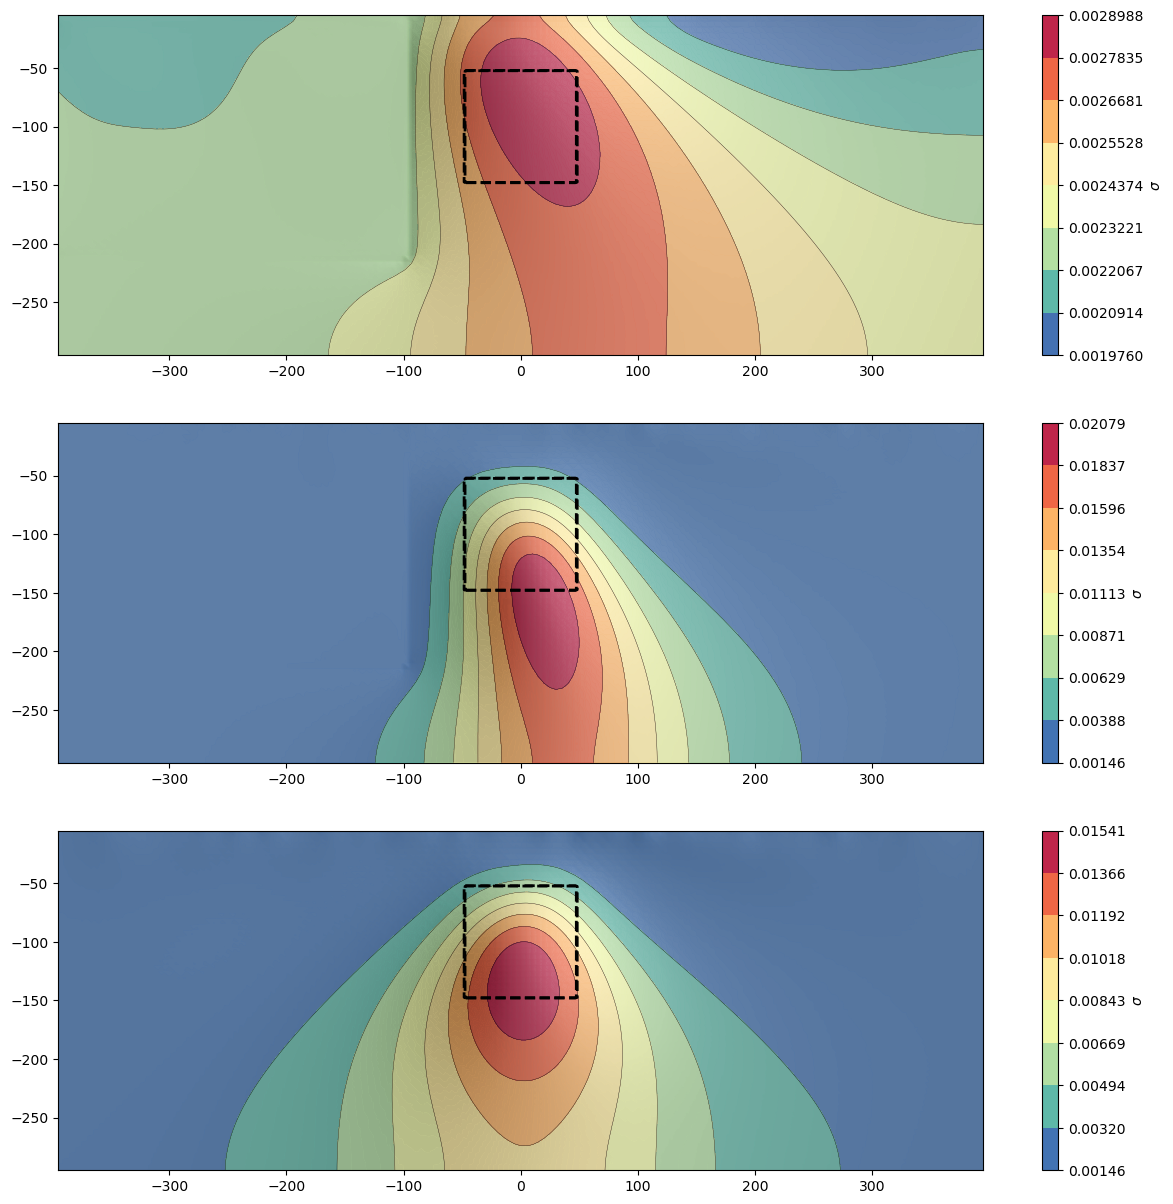

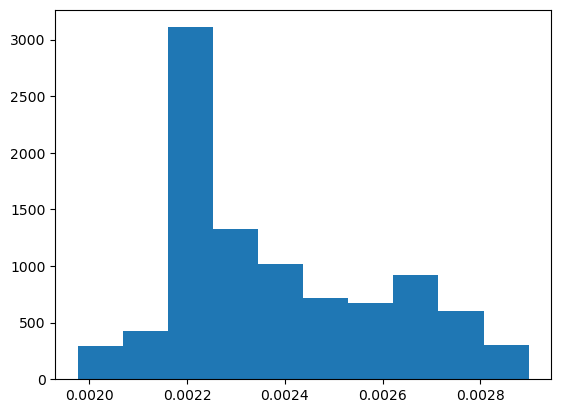

In [5]:
# dip_model = np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/guided/model_11.npy"))
dip_model2 =  np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_27.npy"))
dip_model3 = np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/L2block/model_10.npy"))
dip_model = np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_4.npy"))

fig, ax = plt.subplots(3,1, figsize=(15,15))
clim = [1 / 1000, 1/200]
mm2 = utils.plot2Ddata(

    meshCore.gridCC, dip_model3,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[2],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm2[0], label=r'$\sigma$')

mm = utils.plot2Ddata(

    meshCore.gridCC, dip_model,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[0],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm[0], label=r'$\sigma$')

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

mm1 = utils.plot2Ddata(

    meshCore.gridCC, dip_model2,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[1],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm1[0], label=r'$\sigma$')



# plt.colorbar(mm[0], label=r'$\Omega$ m')
plt.show()

# fig, ax = plt.subplots(1,1)
# mm = meshCore.plot_image(
    
#     # reg_mean.deriv(dip_model),
#     reg_1storder._anis_alpha[:, 0],
#     ax=ax,
#     # clim=[-0.08, 0.08],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# plt.colorbar(mm[0], label=r'$\Omega$ m')
# plt.show()

# print(reg_org(dip_model))
# print(reg_mean(dip_model))

# plt.hist(dip_model2)
plt.hist(dip_model)
plt.show()

## Convergence curves

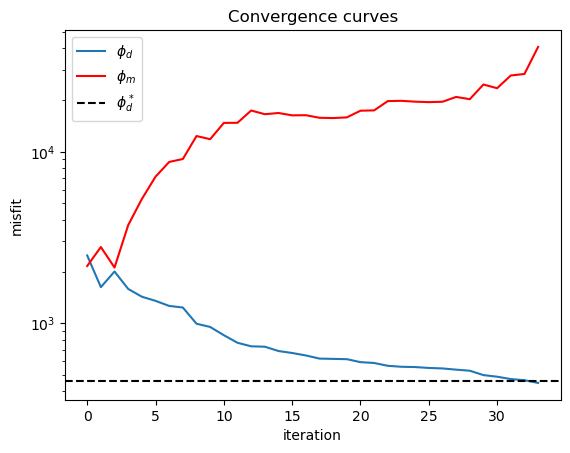

460.0


In [7]:
phi_d = []
phi_m = []
for ii in range(34):
    dip_model = np.load(f"/home/juanito/git/jresearch/geological_segmentation/iterations/model_{ii}.npy")
    phi_d.append(dmis(dip_model))
    phi_m.append(reg_mean(dip_model))

plt.semilogy(phi_d, label=r'$\phi_d$')
plt.semilogy(phi_m, 'r', label=r'$\phi_m$')
plt.axhline(dc_data.dobs.shape[0] / 2, color='k', linestyle='--', label=r'$\phi_d^*$')
plt.xlabel('iteration')
plt.ylabel('misfit')
plt.title('Convergence curves')
plt.legend()
plt.show()
print(dc_data.dobs.shape[0] / 2)

## Do segmentation

In [14]:
segmentor = geoseg.SamClassificationModel(
    meshCore,
    segmentation_model_checkpoint=r"/home/juanito/Documents/trained_models/sam_vit_h_4b8939.pth"
)

masks2 = segmentor.fit(np.log(dip_model2))



mask 0 vote total: 1
mask 1 vote total: 1
mask 2 vote total: 0
[1]
[[1.00000000e+00 1.07515321e-04 0.00000000e+00]
 [1.07515321e-04 0.00000000e+00 2.90609137e-01]
 [0.00000000e+00 2.90609137e-06 1.00000000e+00]]


## Display masks

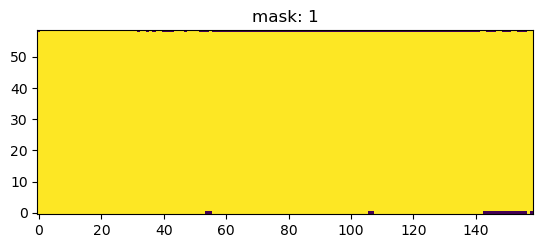

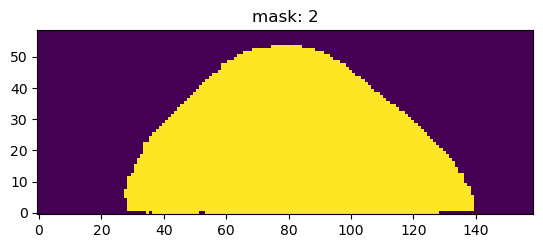

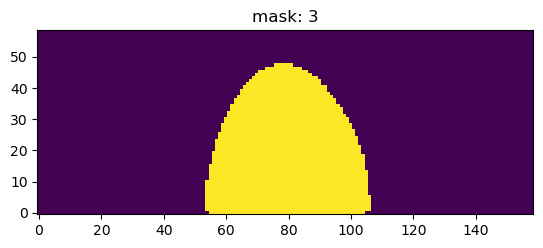

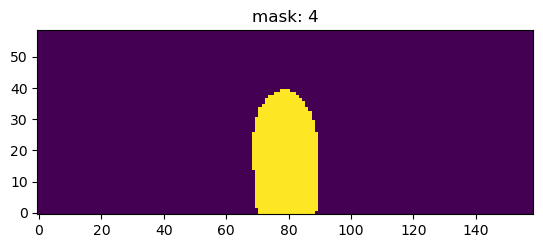

7


In [4]:
results = update_sam.segmentation_model.segmentations.copy()
cnt = 1
for result in results:
    flatten = result['segmentation'].flatten(order='F')
    reshape = flatten.reshape(meshCore.shape_cells, order='F')

    plt.imshow(reshape.T)
    plt.title(f'mask: {cnt}')
    plt.gca().invert_yaxis()
    plt.show()
    cnt += 1
print(len(result))

In [10]:
a = 0
b = 0 #self.segmentations[id]['bbox'][0] - (self.segmentations[id]['bbox'][2] // 2)
id = 0
y0 = update_sam.segmentation_model.segmentations[id]['bbox'][0]
x0 = update_sam.segmentation_model.segmentations[id]['bbox'][1] - (2 * b)
x1 = x0 + update_sam.segmentation_model.segmentations[id]['bbox'][3] + (4 * b)
y1 = y0 + update_sam.segmentation_model.segmentations[id]['bbox'][2] + a

print(x0, x1, y0, y1)

0.0 158.0 0.0 58.0


Text(0.5, 1.0, 'Estimated Regularization Orientations')

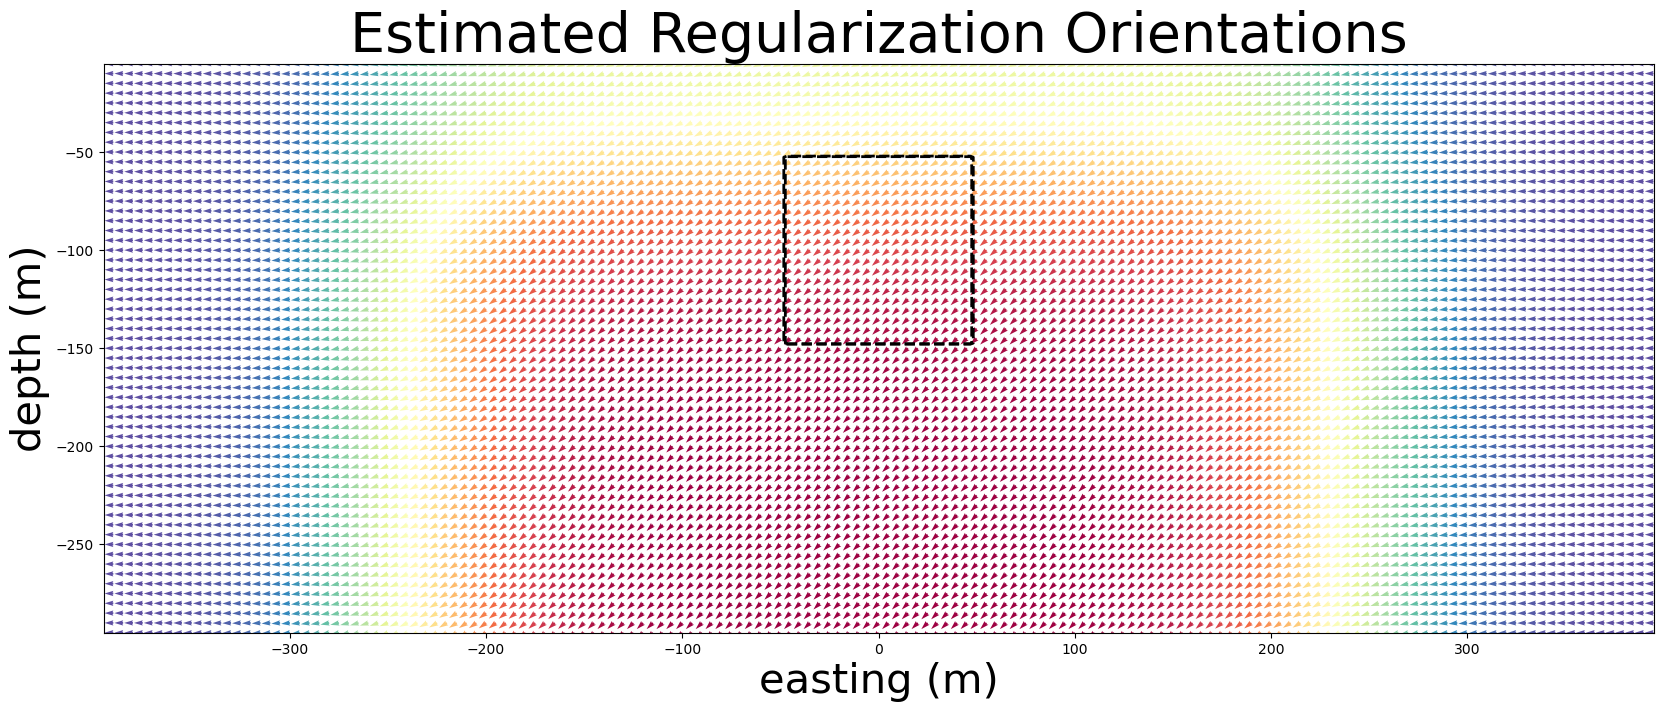

In [9]:
def plot_quiver(x, y, angles, ax=None):
    # Convert angles to radians
    angles_rad = np.radians(angles)

    # Calculate the x and y components of the vectors
    u = np.cos(angles_rad)
    v = np.sin(angles_rad)
    intensity = angles / angles.max()

    # Create a quiver plot
    ax.quiver(x, y, u, v * intensity, intensity, cmap='Spectral')

    # Set the aspect ratio to 'equal'
    ax.axes.set_aspect('equal')

    ax.set_xlabel('easting (m)', fontsize=30)
    ax.set_ylabel('depth (m)', fontsize=30)


# Example usage
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plot_quiver(meshCore.gridCC[:, 0], meshCore.gridCC[:, 1], update_sam.reg_rots.copy() - 90 - 180, ax=ax)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax,
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
# ax.set_xlim([-200, 100])
ax.set_title('Estimated Regularization Orientations', fontsize=40)




mask 0: 335.17353374587225 ohm - m
mask 1: 184.92251659625876 ohm - m
mask 2: 81.63432389926726 ohm - m
mask 3: 538.1096738175161 ohm - m


/tmp/ipykernel_988916/2997340898.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / geological_model, ax=ax, pcolorOpts={'cmap':"Spectral"})


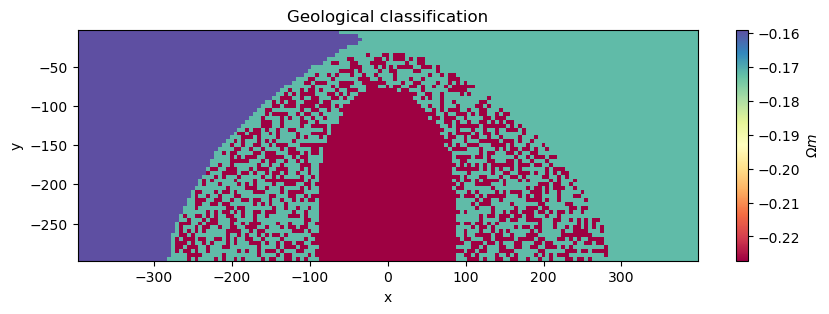

In [12]:
# masks[5]['area']
# bbox.shape
geological_model = segmentor.predict(dip_model)
fig, ax = plt.subplots(1,1, figsize=(10, 3))
dat = meshCore.plotImage(1 / geological_model, ax=ax, pcolorOpts={'cmap':"Spectral"})

# dat = utils.plot2Ddata(

#     meshCore.gridCC, 1 / np.exp(geological_model),nx=500,ny=500,
#     contourOpts={'cmap':"Spectral", 'alpha':1},
#     #clim=[0,5],
#     ax=ax,
#     # level=True,
#     ncontour=10,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     clim=[10, 500],
#     shade_ncontour=100,
#     shade_azimuth=315.0,
#     shade_angle_altitude=45.0,
    
# )
# ax.axis("equal")
ax.set_title('Geological classification')
plt.colorbar(dat[0], label=r'$\Omega m$')

## Analyze the segmentation with PCA

Orientation angle (degrees): 45.00000000000494, [13.79554572 13.77254218], [0.70710678 0.70710678]


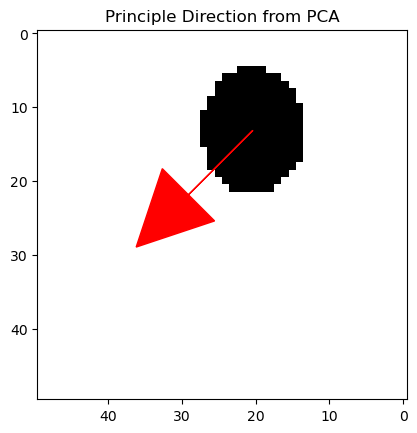

In [36]:
# np.save('iter40-segmentations.npy', masks3[2]['segmentation'])
ii = -1
seg_data = masks2[ii]['segmentation'][50:100, 0:50]
seg_data = np.flip(seg_data)
# Find the coordinates of the object pixels
object_pixels = np.argwhere(seg_data == 1)

# Apply PPCA to determine orientation
if len(object_pixels) > 1:
    # Standardize the data
    scaler = StandardScaler()
    object_pixels_std = scaler.fit_transform(object_pixels)

    # Apply PPCA
    pca = PCA(n_components=2)
    pca.fit(object_pixels_std)

    # The first principal component (eigenvector) will represent the orientation
    orientation_vector = pca.components_[0]

    # Compute the angle of the orientation vector (in degrees)
    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

    print(f"Orientation angle (degrees): {angle_degrees}, {pca.singular_values_}, {orientation_vector}")
else:
    print("Not enough object pixels to determine orientation.")

# Find the center of the object by averaging the object pixel coordinates
object_center = object_pixels.mean(axis=0)

# Plot the mask
plt.imshow(seg_data.T, cmap='binary')

# Plot an arrow representing the orientation
arrow_length = 1
arrow_dx = arrow_length * np.cos(angle_degrees * np.pi / 180)
arrow_dy = arrow_length * np.sin(angle_degrees * np.pi / 180)
plt.arrow(object_center[0], object_center[1], arrow_dx + 8, arrow_dy+ 8,
          head_width=10, head_length=10, fc='r', ec='r')

# Show the plot
plt.gca().invert_xaxis()
plt.title('Principle Direction from PCA')
plt.show()

[-6.5592212982771425, -3.950086864237129]


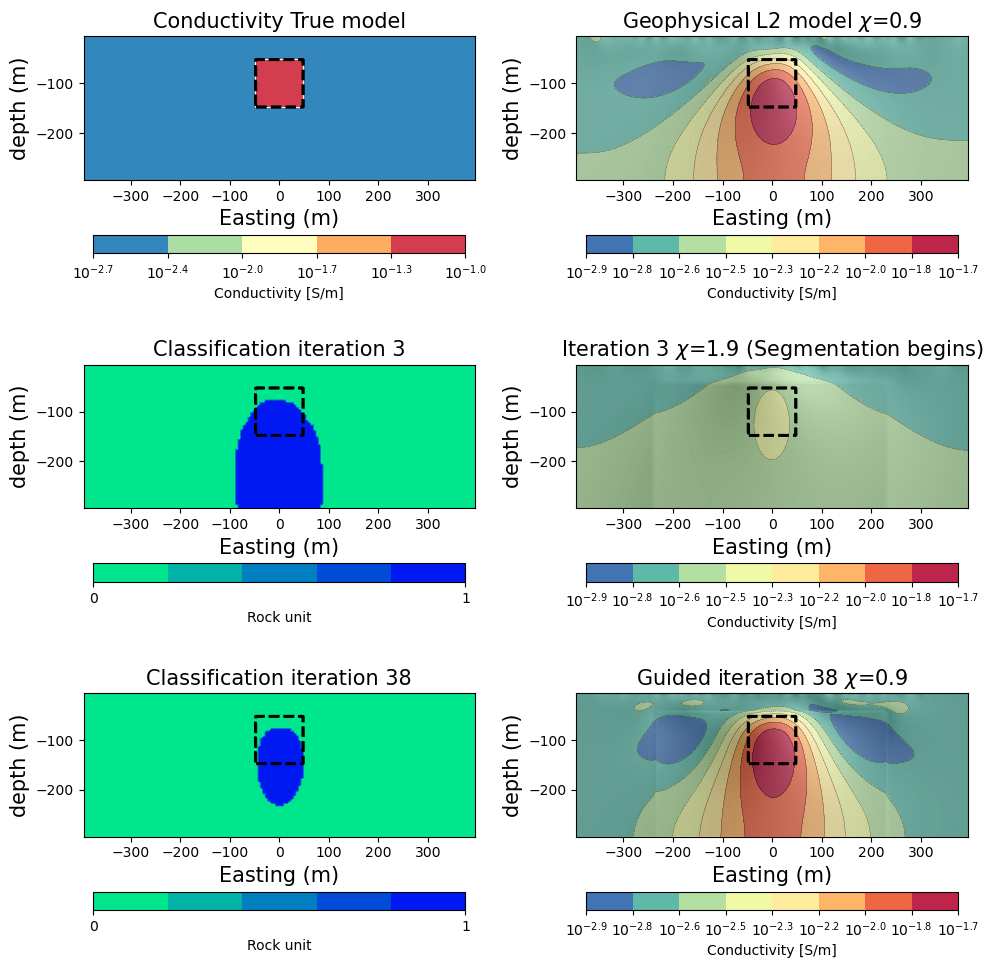

In [18]:
from matplotlib.colors import LogNorm
import matplotlib as mpl

sam_model = segmentor
# masks2 = update_sam.segmentation_model.segmentations
cond_true = mtrue
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# dat = meshCore.plotImage(1 / np.exp(dip_model), ax=ax[0, 1], clim=[10, 500], pcolorOpts={'cmap':"Spectral"})

ax[0, 1].set_title(r'Geophysical L2 model $\chi$=0.9',fontsize=15)
ax[0, 1].set_xlabel('Easting (m)',fontsize=15)
ax[0, 1].set_ylabel('depth (m)',fontsize=15)


ax[0, 0].set_title('Conductivity True model',fontsize=15)
ax[0, 0].set_xlabel('Easting (m)',fontsize=15)
ax[0, 0].set_ylabel('depth (m)',fontsize=15)

ax[1, 0].set_title('Classification iteration 3',fontsize=15)
ax[1, 0].set_xlabel('Easting (m)',fontsize=15)
ax[1, 0].set_ylabel('depth (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[1, 1].set_title(r'Iteration 3 $\chi$=1.9 (Segmentation begins)',fontsize=15)
ax[1, 1].set_xlabel('Easting (m)',fontsize=15)
ax[1, 1].set_ylabel('depth (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[2, 0].set_title('Classification iteration 38',fontsize=15)
ax[2, 0].set_xlabel('Easting (m)',fontsize=15)
ax[2, 0].set_ylabel('depth (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[2, 1].set_title(r'Guided iteration 38 $\chi$=0.9',fontsize=15)
ax[2, 1].set_xlabel('Easting (m)',fontsize=15)
ax[2, 1].set_ylabel('depth (m)',fontsize=15)

# flatten = sam_model.masks[4]['segmentation'].flatten(order='F')
# dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[3, 0], pcolorOpts={'cmap':"winter_r"})
# # ax[1, 1].invert_yaxis()
# ax[3, 0].set_title('segmentation: 5',fontsize=15)
# ax[3, 1].axis('off')
clim = [dip_model3.min(), dip_model3.max()]
print(clim)
# subplot 0,0 ----------------------------------------------------------
flatten = (cond_true)[actcore]
conductivity_model_log10_true = np.log10(np.exp(flatten))
# dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral"})
d1 = utils.plot2Ddata(

    meshCore.gridCC, conductivity_model_log10_true,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[0, 0],
    # level=True,
    ncontour=5,
    # shade=True,
    # levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

norm = mpl.colors.Normalize(
    vmin=conductivity_model_log10_true.min(), vmax=conductivity_model_log10_true.max()
)

plt.colorbar(d1[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)


# subplot 0,1 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0, 1],
    level=True,
    ncontour=2,
    # shade=True,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

dip_model3 = np.load(r"/home/juanito/git/jresearch/geological_segmentation/L2block/model_14.npy")
conductivity_model_log10 = np.log10(np.exp(dip_model3))
dip_model2_1 = np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_33.npy")
conductivity_model_log10_2_1 = np.log10(np.exp(dip_model2_1))
clim = [conductivity_model_log10_2_1.min(), conductivity_model_log10_2_1.max()]
d2 = utils.plot2Ddata(

    meshCore.gridCC, conductivity_model_log10, nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[0, 1],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)

norm = mpl.colors.Normalize(
    vmin=conductivity_model_log10.min(), vmax=conductivity_model_log10.max()
)

plt.colorbar(d2[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)

# subplot 1,0 ----------------------------------------------------------
masks = update_sam.segmentation_model.segmentations.copy()

flatten = masks[2]['segmentation'].flatten(order='F')  # np.load('iter40-segmentations.npy').astype(int).flatten(order='F')

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    ax=ax[1, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

d3 = utils.plot2Ddata(

    meshCore.gridCC, flatten,nx=500,ny=500,
    contourOpts={'cmap':"winter_r", 'alpha':1},
    ax=ax[1, 0],
    level=False,
    ncontour=5,
    # shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    
)

# norm_seg = mpl.colors.Normalize(
#     vmin=conductivity_model_log10_seg.min(), vmax=conductivity_model_log10_seg.max()
# )

plt.colorbar(d3[0], cmap='winter_r', orientation="horizontal", label='Rock unit', ticks=[0,1], pad=0.2, shrink=0.95)

# subplot 1,1 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

dip_model1_1 = np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_2.npy")
conductivity_model_log10_1_1 = np.log10(np.exp(dip_model1_1))
d5 = utils.plot2Ddata(

    meshCore.gridCC, conductivity_model_log10_1_1,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[1, 1],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)

# norm = mpl.colors.Normalize(
#     vmin=conductivity_model_log10_seg.min(), vmax=conductivity_model_log10_seg.max()
# )

plt.colorbar(d5[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)

# subplot 2,0 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

flatten = masks2[-1]['segmentation'].flatten(order='F')
d6 = utils.plot2Ddata(

    meshCore.gridCC, flatten,nx=500,ny=500,
    contourOpts={'cmap':"winter_r", 'alpha':1},
    #clim=[0,5],
    ax=ax[2, 0],
    level=False,
    ncontour=5,
    # shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    
)
plt.colorbar(d6[0], cmap='winter_r', orientation="horizontal", label='Rock unit', ticks=[0,1], pad=0.2, shrink=0.95)

# subplot 2,1 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

# flatten = masks3[3]['segmentation'].flatten(order='F')
dip_model2_1 = np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_33.npy")
conductivity_model_log10_2_1 = np.log10(np.exp(dip_model2_1))
d7 = utils.plot2Ddata(

    meshCore.gridCC, conductivity_model_log10_2_1,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[2, 1],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(d7[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)

plt.tight_layout()

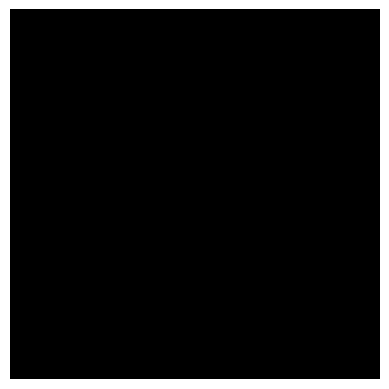

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to render points using Gaussian splatting
def gaussian_splatting(points, colors, radii, image_size, camera_pos, fov):
    # Create a blank image
    image = torch.zeros((image_size, image_size, 3), dtype=torch.float32)
    
    # Calculate the focal length based on the field of view (FOV)
    focal_length = image_size / (2 * torch.tan(torch.deg2rad(fov / 2)))
    
    # Iterate over each point
    for i in range(points.shape[0]):
        # Get the point position and color
        point_pos = points[i]
        color = colors[i]
        radius = radii[i]
        
        # Calculate the 2D position on the image plane using perspective projection
        z_distance = point_pos[2] - camera_pos[2]
        if z_distance <= 0:
            continue  # Skip points behind the camera
        
        # Perspective projection
        u = focal_length * (point_pos[0] - camera_pos[0]) / z_distance + image_size // 2
        v = focal_length * (point_pos[1] - camera_pos[1]) / z_distance + image_size // 2
        
        # Convert coordinates to integers
        u, v = int(u), int(v)
        
        # Apply adaptive densification based on the distance from the camera
        adaptive_radius = max(radius * focal_length / z_distance, 1)
        
        # Create a Gaussian kernel
        size = int(2 * adaptive_radius + 1)
        x = torch.linspace(-adaptive_radius, adaptive_radius, size)
        y = torch.linspace(-adaptive_radius, adaptive_radius, size)
        x, y = torch.meshgrid(x, y)
        gaussian_kernel = torch.exp(-(x**2 + y**2) / (2 * (adaptive_radius**2)))
        
        # Normalize the kernel
        gaussian_kernel /= gaussian_kernel.sum()
        
        # Define bounds for the kernel
        u_min = max(0, u - size // 2)
        u_max = min(image_size, u + size // 2 + 1)
        v_min = max(0, v - size // 2)
        v_max = min(image_size, v + size // 2 + 1)
        
        # Add the weighted kernel to the image
        image[v_min:v_max, u_min:u_max] += color * gaussian_kernel
        
    # Clip image values to the range [0, 1]
    image = image.clamp(0, 1)
    
    return image

# Main function

# Set random seed for reproducibility
torch.manual_seed(42)

# Define parameters
num_points = 1000
image_size = 256
camera_pos = torch.tensor([0, 0, 10], dtype=torch.float32)  # Camera position
fov = torch.tensor([60])  # Field of view in degrees

# Generate random points, colors, and radii
points = torch.rand((num_points, 3)) * 10 - 5  # Points in [-5, 5] range
colors = torch.rand((num_points, 3))  # RGB colors
radii = torch.rand(num_points) * 0.5 + 0.1  # Radii in [0.1, 0.6] range

# Perform Gaussian splatting
image = gaussian_splatting(points, colors, radii, image_size, camera_pos, fov)

# Convert image to numpy array for plotting
image_np = image.numpy()

# Plot the rendered image
plt.imshow(image_np)
plt.axis("off")
plt.show()
